In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

# HC

In [6]:
pca_result = pd.read_csv('./data/minmax_scaling_PCA.csv', index_col='행정동명')

In [7]:
pca_result

,0,1,2,3,4,5
행정동명,,,,,,
가락1동,0.313751,-0.194982,-0.059432,-0.178299,0.034524,-0.083174
가락2동,0.416137,-0.051024,0.035967,-0.002984,-0.078425,0.073808
가락본동,0.156997,0.112429,0.042758,0.028743,-0.027314,0.151885
가리봉동,-0.612605,0.107408,-0.156476,0.051506,-0.025351,-0.021620
가산동,-0.117360,0.795470,0.181084,-0.224243,0.009892,-0.060995
...,...,...,...,...,...,...
효창동,-0.220963,-0.147393,-0.076008,-0.179221,0.013815,0.064513
후암동,-0.173475,-0.012163,-0.079110,-0.033911,-0.037622,-0.009051
휘경1동,-0.266365,0.178560,-0.087341,-0.182468,-0.011273,-0.015696


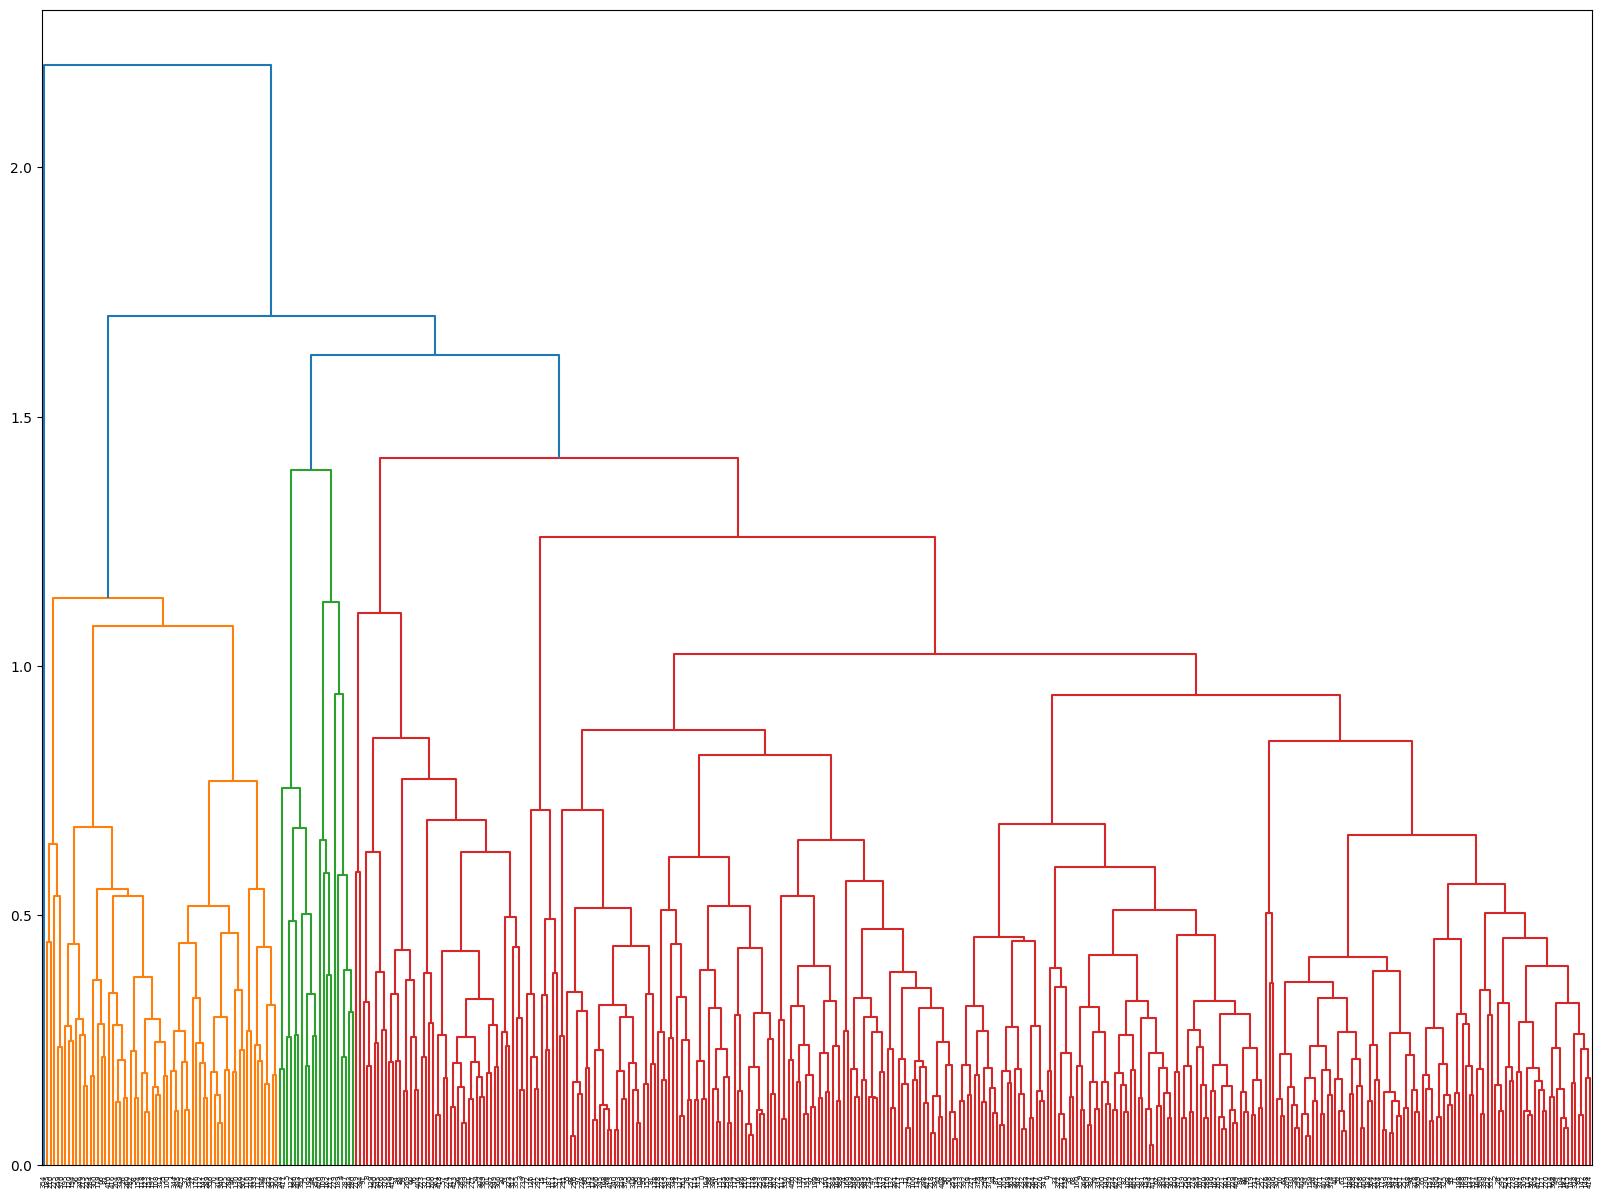

In [9]:
#그래프 그리기
plt.figure(figsize = (20, 15))
clusters = linkage(pca_result, method='complete', metric='euclidean')
dendrogram(clusters)
plt.show()

In [10]:
clusters.shape 

(425, 4)

In [11]:
cut_tree = fcluster(clusters, t=3, criterion='distance')
pca_result['cluster_label']=cut_tree
pca_result['cluster_label'].value_counts()

cluster_label
1    426
Name: count, dtype: int64

# GMM

In [20]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

In [21]:
pca_result = pd.read_csv('./data/minmax_scaling_PCA.csv', index_col='행정동명')

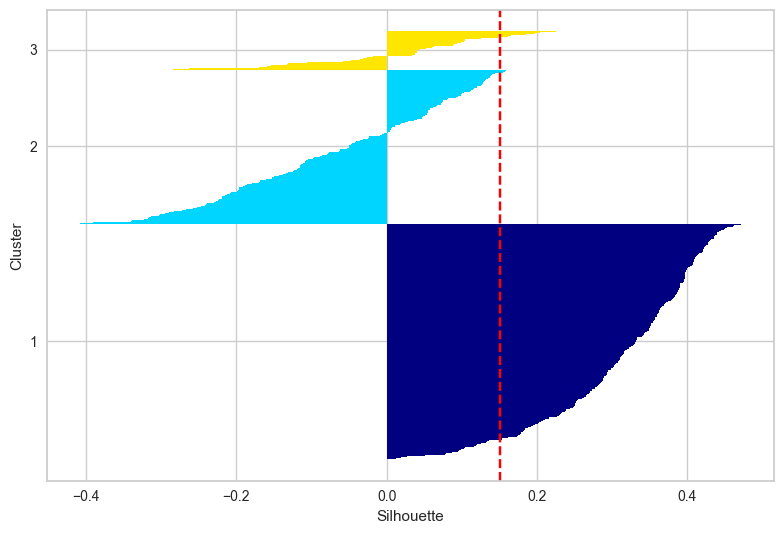

In [22]:
gmm=GaussianMixture(n_components= 3, random_state=0).fit(pca_result)

y_km = gmm.fit_predict(pca_result)

cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]

#실루엣 분석
silhouette_vals = silhouette_samples(pca_result, y_km, metric = 'euclidean')

#시각화
y_ax_lower, y_ax_upper = 0, 0
yticks = []

for i, c in enumerate(cluster_labels) :
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(i/n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height = 1.0,
             edgecolor = 'none', color = color)
    yticks.append((y_ax_lower + y_ax_upper) / 2)
    y_ax_lower += len(c_silhouette_vals)

#라벨링
pca_result['cluster'] = gmm.predict(pca_result)
#실루엣계수 평균값
silhouette_avg = np.mean(silhouette_vals)

plt.axvline(silhouette_avg, color = 'red', linestyle='--')
plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette')

plt.tight_layout()
plt.show()

In [23]:
pca_result

,0,1,2,3,4,5,cluster
행정동명,,,,,,,
가락1동,0.313751,-0.194982,-0.059432,-0.178299,0.034524,-0.083174,0
가락2동,0.416137,-0.051024,0.035967,-0.002984,-0.078425,0.073808,1
가락본동,0.156997,0.112429,0.042758,0.028743,-0.027314,0.151885,1
가리봉동,-0.612605,0.107408,-0.156476,0.051506,-0.025351,-0.021620,0
가산동,-0.117360,0.795470,0.181084,-0.224243,0.009892,-0.060995,2
...,...,...,...,...,...,...,...
효창동,-0.220963,-0.147393,-0.076008,-0.179221,0.013815,0.064513,0
후암동,-0.173475,-0.012163,-0.079110,-0.033911,-0.037622,-0.009051,0
휘경1동,-0.266365,0.178560,-0.087341,-0.182468,-0.011273,-0.015696,0


In [24]:
pca_result['cluster'].value_counts()

cluster
0    234
1    154
2     38
Name: count, dtype: int64

<Axes: xlabel='V_0', ylabel='V_1'>

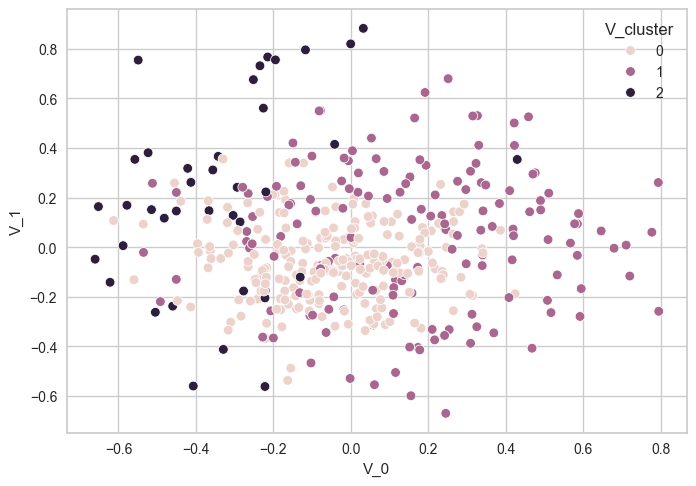

In [25]:
import seaborn as sns

pca_result_T = pca_result.reset_index().copy()

pca_result_T.columns = ['V_' + str(x) for x in pca_result_T.columns]

sns.scatterplot(data = pca_result_T.reset_index(), x = 'V_0', y = 'V_1', hue = 'V_cluster')

# DBSCAN

In [29]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import OneHotEncoder

In [40]:
pca_result = pd.read_csv('./data/minmax_scaling_PCA.csv', index_col='행정동명')

In [41]:
#DBSCAN 설치를 위한 패키지
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

0.3573328087215412


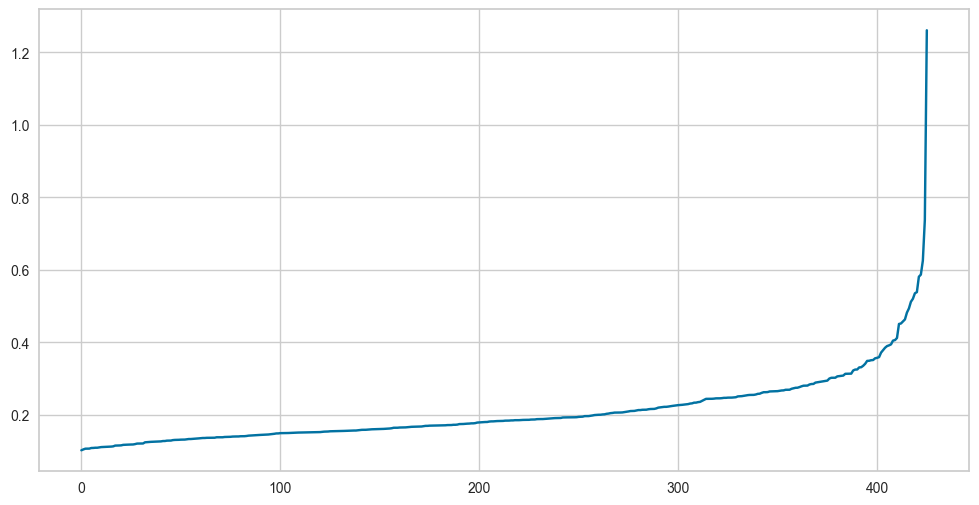

In [42]:
#스케일링 한 데이터
neigh = NearestNeighbors(n_neighbors=5)
neigh.fit(pca_result)
distances, indices = neigh.kneighbors(pca_result) # 각 개체마다 거리를 계산해서 가까운 거리의 5개와 그 떄의 index 반환

# 4-dist를 plotting 해보기
# 저 빨간점에서 급격히 4-dist가 급증하였다 -> 우리는 이 때의 distance인 18을 eps로, 4를 minpts로 잡고 DBSCAN을 진행해보도록 하자.
plt.figure(figsize=(12, 6))
plt.plot(np.sort(distances[:, 4]))

print(np.sort(distances[:, 4])[400])

#0.5228570147560503

0.3573328087215412


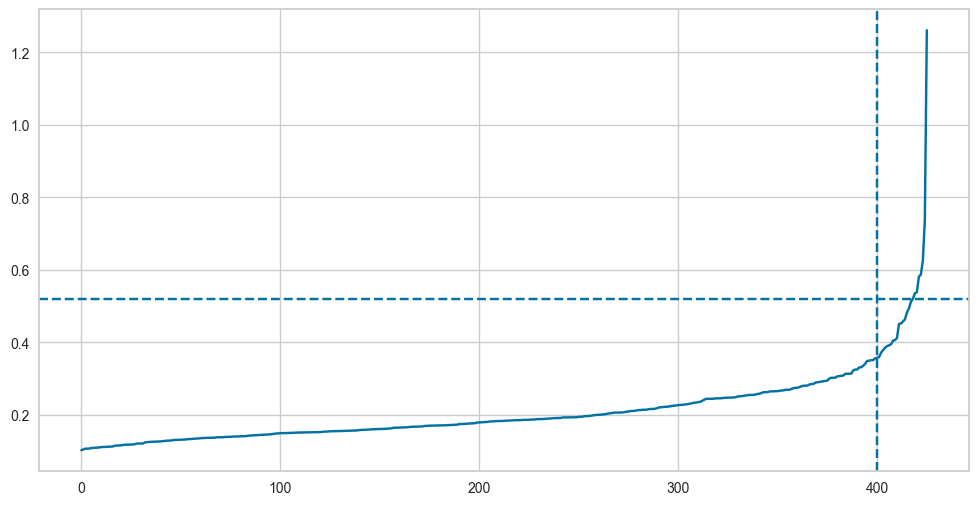

In [43]:
#스케일링 한 데이터
neigh = NearestNeighbors(n_neighbors=5) # default 값
neigh.fit(pca_result)
distances, indices = neigh.kneighbors(pca_result) # 각 개체마다 거리를 계산해서 가까운 거리의 5개와 그 떄의 index 반환

# 4-dist를 plotting 해보기
# 저 빨간점에서 급격히 4-dist가 급증하였다 -> 우리는 이 때의 distance인 18을 eps로, 4를 minpts로 잡고 DBSCAN을 진행해보도록 하자.
plt.figure(figsize=(12, 6))
plt.plot(np.sort(distances[:, 4]))
plt.axvline(400, 0, 4, ls='--')
plt.axhline(0.52, 0, 400, ls='--')

print(np.sort(distances[:, 4])[400])

#eps(점으로 부터의 반경) 가 0.5228570147560503 일때 최적의 값임을 알수있음 

### 참고 자료
DBSCAN(eps=0.522, min_samples=12)
https://rfriend.tistory.com/588

In [58]:
dbscan = DBSCAN(eps=0.3, min_samples=3) # DBSCAN 학습 보통 (차원수) *2 를 min_samples로 둠
#eps=0.522 [-1  0] => 군집 2개로 잡힘 min_samples

#eps=0.522, min_samples=2 => 군집 3개로 잡힌걸로 설정 [-1  0  1]
 
dbscan.fit(pca_result)

print(np.unique(dbscan.labels_))

[-1  0  1]


In [54]:
pd.Series(dbscan.labels_).value_counts() #2개의 군집

 0    403
-1     20
 1      3
Name: count, dtype: int64

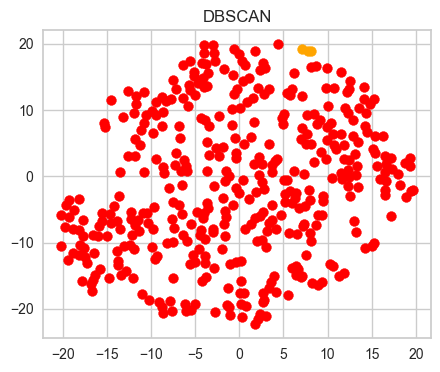

In [59]:
# Assign result to df
dataset = pd.DataFrame({'Column1':transformed[:,0],'Column2':transformed[:,1]})
dataset['cluster_num'] = pd.Series(dbscan.labels_)

# Cluster Viz 1
plt.rcParams['figure.figsize'] = [5, 4]
plt.scatter(dataset[dataset['cluster_num'] == 0]['Column1'], 
            dataset[dataset['cluster_num'] == 0]['Column2'], 
            s = 50, c = 'red', label = 'Customer Group 1')
plt.scatter(dataset[dataset['cluster_num'] == 1]['Column1'], 
            dataset[dataset['cluster_num'] == 1]['Column2'], 
            s = 50, c = 'orange', label = 'Customer Group 2')
plt.scatter(dataset[dataset['cluster_num'] == 2]['Column1'], 
            dataset[dataset['cluster_num'] == 2]['Column2'], 
            s = 50, c = 'yellow', label = 'Customer Group 3')
# plt.scatter(dataset[dataset['cluster_num'] == 3]['Column1'], 
#             dataset[dataset['cluster_num'] == 3]['Column2'], 
#             s = 50, c = 'green', label = 'Customer Group 4')
plt.title('DBSCAN')
plt.show()

In [60]:
dataset

,Column1,Column2,cluster_num
0,-3.717400,-15.219904,0
1,-12.045187,-15.352839,0
2,-11.877069,-10.953783,0
3,0.692317,16.827667,0
4,-13.866857,13.919852,-1
...,...,...,...
421,12.478164,13.259111,0
422,1.290674,5.985980,0
423,-5.703203,13.837332,0
424,-6.658098,5.865806,0
